In [1]:
this_notebook_name = "BreastSegmentationStudy-TF2"

# Update this folder name for your computer

local_data_folder = r"c:\Data\BreastSegmentation"
overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

import datetime
save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print("Save timestamp: {}".format(save_timestamp))

# Learning parameters

import numpy as np

ultrasound_size = 128
num_classes = 2
num_epochs = 200
batch_size = 64
max_learning_rate = 0.02
min_learning_rate = 0.000001
regularization_rate = 0.0001
filter_multiplier = 15
class_weights = np.array([0.15, 0.85])
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Training data augmentation parameters

max_shift_factor = 0.12
max_rotation_angle = 10
max_zoom_factor = 1.1
min_zoom_factor = 0.8

# Evaluation parameters

acceptable_margin_mm = 1.0
mm_per_pixel = 1.0

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]

'''
Provide NxM numpy array to schedule cross validation
N rounds of validation will be performed, leaving out M patients in each for validation data
All values should be valid patient IDs, or negative. Negative values are ignored.

Example 1: a leave-one-out cross validation with 3 patients would look like this:
validation_schedule_patient = np.array([[0],[1],[2]])

Example 2: a leave-two-out cross validation on 10 patients would look like this:
validation_schedule_patient = np.array([[0,1],[2,3],[4,5],[6,7],[8,9]])

Example 3: leave-one-out cross validation with 3 patients, then training on all available data (no validation):
validation_schedule_patient = np.array([[0],[1],[2],[-1]])
'''
validation_schedule_patient = np.array([[0,1,2,3], [7,11,13,18], [20,23,27,30]])

# Uncomment for faster debugging

# roc_thresholds = [0.8, 0.6, 0.4, 0.2, 0.1, 0.01, 0.001]
# num_epochs = 5

Save timestamp: 2020-06-28_22-32-52


In [2]:
import os
from random import sample
from pathlib import Path

from ipywidgets import IntProgress
from IPython.display import display, HTML

import girder_client
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

import ultrasound_batch_generator as generator
import evaluation_metrics

from girder_apikey import girder_apikey

In [3]:
# Getting a clone of AIGT

aigt_folder = Path('aigt')

if aigt_folder.exists():
    print("Updating aigt clone")
    !git -C aigt pull
else:
    print("Cloning aigt")
    !git clone -q https://github.com/SlicerIGT/aigt.git

import aigt.Models.segmentation_unet as unet
import aigt.utils

Updating aigt clone


error: Pulling is not possible because you have unmerged files.
hint: Fix them up in the work tree, and then use 'git add/rm <file>'
hint: as appropriate to mark resolution and make a commit.
fatal: Exiting because of an unresolved conflict.


In [4]:
# Creating standard folders to save data and logs

data_arrays_fullpath, notebooks_save_fullpath, results_save_fullpath, models_save_fullpath, val_data_fullpath =\
    aigt.utils.create_standard_project_folders(local_data_folder)

In [5]:
# Fetching Girder data

girder_url = "https://pocus.cs.queensu.ca/api/v1"
data_csv_file = "BreastGirder.csv"
girder_key = girder_apikey

ultrasound_arrays_by_patients, segmentation_arrays_by_patients =\
    aigt.utils.load_girder_data(data_csv_file, data_arrays_fullpath, girder_url, girder_key)
    
n_patients = len(ultrasound_arrays_by_patients)

for i in range(n_patients):
    print("Patient {} has {} ultrasounds and {} segmentations".format(
        i, ultrasound_arrays_by_patients[i].shape[0], segmentation_arrays_by_patients[i].shape[0]))

Patient 0 has 379 ultrasounds and 379 segmentations
Patient 1 has 292 ultrasounds and 292 segmentations
Patient 2 has 426 ultrasounds and 426 segmentations
Patient 3 has 418 ultrasounds and 418 segmentations
Patient 4 has 442 ultrasounds and 442 segmentations
Patient 5 has 224 ultrasounds and 224 segmentations
Patient 6 has 272 ultrasounds and 272 segmentations
Patient 7 has 288 ultrasounds and 288 segmentations
Patient 8 has 175 ultrasounds and 175 segmentations
Patient 9 has 113 ultrasounds and 113 segmentations
Patient 10 has 237 ultrasounds and 237 segmentations
Patient 11 has 180 ultrasounds and 180 segmentations
Patient 12 has 5 ultrasounds and 5 segmentations
Patient 13 has 402 ultrasounds and 402 segmentations
Patient 14 has 295 ultrasounds and 295 segmentations
Patient 15 has 331 ultrasounds and 331 segmentations
Patient 16 has 145 ultrasounds and 145 segmentations
Patient 17 has 253 ultrasounds and 253 segmentations
Patient 18 has 158 ultrasounds and 158 segmentations
Patient

In [6]:
# Prepare validation rounds

if np.max(np.max(validation_schedule_patient)) > (n_patients - 1):
    raise Exception("Patient ID cannot be greater than {}".format(n_patients - 1))

num_validation_rounds = len(validation_schedule_patient)
print("Planning {} rounds of validation".format(num_validation_rounds))
for i in range(num_validation_rounds):
    print("Validation on patients {} in round {}".format(validation_schedule_patient[i], i))

Planning 3 rounds of validation
Validation on patients [0 1 2 3] in round 0
Validation on patients [ 7 11 13 18] in round 1
Validation on patients [20 23 27 30] in round 2


Timestamp for saved files: 2020-06-28_22-32-52

Training parameters
Number of epochs:    200
Step size maximum:   0.02
Step size decay:     9.9995e-05
Batch size:          64
Regularization rate: 0.0001

Saving validation predictions in: c:\Data\BreastSegmentation\PredictionsValidation
Saving models in:                 c:\Data\BreastSegmentation\SavedModels

*** Leave-one-out round # 0
    Training on 5803 images, validating on 1515 images...
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  Training time: 6:05:28.586327
(1515, 128, 128, 1)

Total round time:  6:06:08.603849


*** Leave-one-out round # 1
    Training on 6290 images, validating on 1028 images...
  ...
    to  
  ['...']
  Training time: 6:29:20.539325
(1028, 128, 128, 1)

Total round time:  6:29:47.579054


*** Leave-one-out round # 2
    Training on 6689 images, validating on 629 images...
  ...
    to  
  ['...']
  Training time: 6:48:18.492590
(629, 128, 128, 1)

T

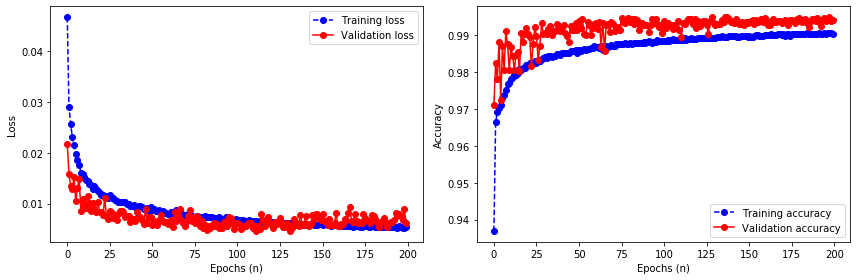

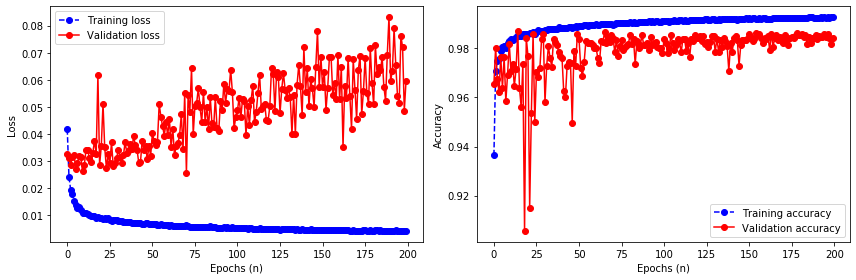

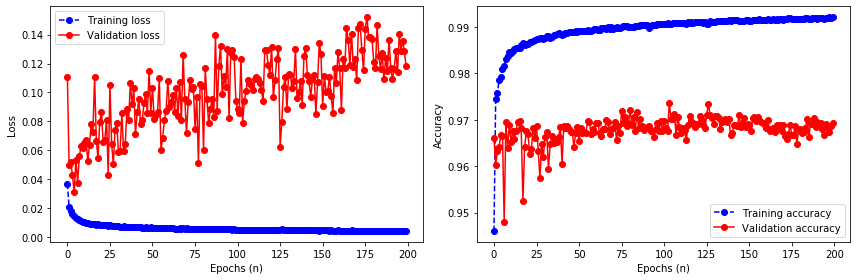

In [7]:
# Print training parameters, to archive them together with the notebook output.

time_sequence_start = datetime.datetime.now()

print("Timestamp for saved files: {}".format(save_timestamp))
print("\nTraining parameters")
print("Number of epochs:    {}".format(num_epochs))
print("Step size maximum:   {}".format(max_learning_rate))
print("Step size decay:     {}".format(learning_rate_decay))
print("Batch size:          {}".format(batch_size))
print("Regularization rate: {}".format(regularization_rate))
print("")
print("Saving validation predictions in: {}".format(val_data_fullpath))
print("Saving models in:                 {}".format(models_save_fullpath))

# ROC data will be saved in these containers

val_best_metrics    = dict()
val_fuzzy_metrics   = dict()
val_aurocs          = np.zeros(num_validation_rounds)
val_best_thresholds = np.zeros(num_validation_rounds)

# Perform validation rounds

for val_round_index in range(num_validation_rounds):
    
    # Prepare data arrays
    
    train_ultrasound_data = np.zeros(
        [0,
         ultrasound_arrays_by_patients[0].shape[1],
         ultrasound_arrays_by_patients[0].shape[2],
         ultrasound_arrays_by_patients[0].shape[3]])
    
    train_segmentation_data = np.zeros(
        [0,
         segmentation_arrays_by_patients[0].shape[1],
         segmentation_arrays_by_patients[0].shape[2],
         segmentation_arrays_by_patients[0].shape[3]])
    
    val_ultrasound_data = np.zeros(
        [0,
         ultrasound_arrays_by_patients[0].shape[1],
         ultrasound_arrays_by_patients[0].shape[2],
         ultrasound_arrays_by_patients[0].shape[3]])
    
    val_segmentation_data = np.zeros(
        [0,
         segmentation_arrays_by_patients[0].shape[1],
         segmentation_arrays_by_patients[0].shape[2],
         segmentation_arrays_by_patients[0].shape[3]])
    
    for patient_index in range(n_patients):
        if patient_index not in validation_schedule_patient[val_round_index]:
            train_ultrasound_data = np.concatenate((train_ultrasound_data,
                                                    ultrasound_arrays_by_patients[patient_index]))
            train_segmentation_data = np.concatenate((train_segmentation_data,
                                                      segmentation_arrays_by_patients[patient_index]))
        else:
            val_ultrasound_data = np.concatenate((val_ultrasound_data,
                                                 ultrasound_arrays_by_patients[patient_index]))
            val_segmentation_data = np.concatenate((val_segmentation_data,
                                                   segmentation_arrays_by_patients[patient_index]))
    
    n_train = train_ultrasound_data.shape[0]
    n_val = val_ultrasound_data.shape[0]
    
    print("\n*** Leave-one-out round # {}".format(val_round_index))
    print("    Training on {} images, validating on {} images...".format(n_train, n_val))
    
    val_segmentation_data_onehot = tf.keras.utils.to_categorical(val_segmentation_data, num_classes)
    
    # Create and train model
    
    model = unet.segmentation_unet(ultrasound_size, num_classes, filter_multiplier, regularization_rate)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=max_learning_rate, decay=learning_rate_decay),
        loss=unet.weighted_categorical_crossentropy(class_weights),
        metrics=["accuracy"]
    )
    
    # model.summary()
        
    training_generator = generator.UltrasoundSegmentationBatchGenerator(
        train_ultrasound_data,
        train_segmentation_data[:, :, :, 0],
        batch_size,
        (ultrasound_size, ultrasound_size),
        max_shift_factor=max_shift_factor,
        min_zoom_factor=min_zoom_factor,
        max_zoom_factor=max_zoom_factor,
        max_rotation_angle=max_rotation_angle
    )
        
    training_time_start = datetime.datetime.now()
    
    if n_val > 0:
        training_log = model.fit_generator(
            training_generator,
            validation_data=(val_ultrasound_data, val_segmentation_data_onehot),
            epochs=num_epochs,
            verbose=0)
    else:
        training_log = model.fit_generator(training_generator, epochs=num_epochs, verbose=0)
    
    training_time_stop = datetime.datetime.now()
    
    # Pring training log
    
    print("  Training time: {}".format(training_time_stop-training_time_start))
    
    # Plot training loss and metrics
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    axes[0].plot(training_log.history['loss'], 'bo--')
    if n_val > 0:
        axes[0].plot(training_log.history['val_loss'], 'ro-')
    axes[0].set(xlabel='Epochs (n)', ylabel='Loss')
    if n_val > 0:
        axes[0].legend(['Training loss', 'Validation loss'])
    
    axes[1].plot(training_log.history['accuracy'], 'bo--')
    if n_val > 0:
        axes[1].plot(training_log.history['val_accuracy'], 'ro-')
    axes[1].set(xlabel='Epochs (n)', ylabel='Accuracy')
    if n_val > 0:
        axes[1].legend(['Training accuracy', 'Validation accuracy'])
    
    fig.tight_layout()
    
    # Archive trained model with unique filename based on notebook name and timestamp
    model_file_name = this_notebook_name + "_model-" + str(val_round_index) + "_" + save_timestamp + ".h5"
    model_fullname = os.path.join(models_save_fullpath, model_file_name)
    model.save(model_fullname)

    # Predict on validation data
    
    if n_val > 0:
        print(val_ultrasound_data.shape)
        y_pred_val  = model.predict(val_ultrasound_data)

        # Saving predictions for further evaluation

        val_prediction_filename = save_timestamp + "_prediction_" + str(val_round_index) + ".npy"
        val_prediction_fullname = os.path.join(val_data_fullpath, val_prediction_filename)
        np.save(val_prediction_fullname, y_pred_val)
        
        # Validation results

        vali_metrics_dicts, vali_best_threshold_index, vali_area = evaluation_metrics.compute_roc(
            roc_thresholds, y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)

        val_fuzzy_metrics[val_round_index] = evaluation_metrics.compute_evaluation_metrics(
            y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)

        val_best_metrics[val_round_index]    = vali_metrics_dicts[vali_best_threshold_index]
        val_aurocs[val_round_index]          = vali_area
        val_best_thresholds[val_round_index] = roc_thresholds[vali_best_threshold_index]
    
    # Printing total time of this validation round
    
    print("\nTotal round time:  {}".format(datetime.datetime.now() - training_time_start))
    print("")


time_sequence_stop = datetime.datetime.now()

print("\nTotal training time:   {}".format(time_sequence_stop - time_sequence_start))


In [8]:
# Arrange results in tables

metric_labels = [
    "AUROC",
    "best thresh",
    "best TP",
    "best FP",
    "best recall",
    "best precis",
    "fuzzy recall",
    "fuzzy precis",
    "fuzzy Fscore"
]

results_labels = []

for label in metric_labels:
    results_labels.append("Vali " + label)

results_df = pd.DataFrame(columns = results_labels)

for i in range(num_validation_rounds):
    if i in val_best_metrics.keys():
        results_df.loc[i] = [
            val_aurocs[i],
            val_best_thresholds[i],
            val_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE],
            val_best_metrics[i][evaluation_metrics.FALSE_POSITIVE_RATE],
            val_best_metrics[i][evaluation_metrics.RECALL],
            val_best_metrics[i][evaluation_metrics.PRECISION],
            val_fuzzy_metrics[i][evaluation_metrics.RECALL],
            val_fuzzy_metrics[i][evaluation_metrics.PRECISION],
            val_fuzzy_metrics[i][evaluation_metrics.FSCORE]
        ]

display(results_df)

print("\nAverages")

results_means_df = results_df.mean()
display(results_means_df)

,Vali AUROC,Vali best thresh,Vali best TP,Vali best FP,Vali best recall,Vali best precis,Vali fuzzy recall,Vali fuzzy precis,Vali fuzzy Fscore
0,0.989168,0.004,0.981364,0.029559,0.981364,0.218671,0.753234,0.598447,0.666978
1,0.604585,0.001,0.619365,0.079175,0.619365,0.090488,0.237716,0.278702,0.256583
2,0.747804,0.001,0.762044,0.068101,0.762044,0.283930,0.300923,0.572231,0.394427



Averages


Vali AUROC           0.780519
Vali best thresh     0.002000
Vali best TP         0.787591
Vali best FP         0.058945
Vali best recall     0.787591
Vali best precis     0.197696
Vali fuzzy recall    0.430625
Vali fuzzy precis    0.483127
Vali fuzzy Fscore    0.439329
dtype: float64

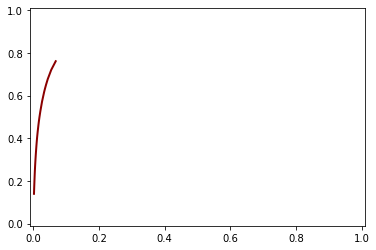

In [9]:
# Print the last ROC curve for visual verification that we catch the optimal point

n = len(roc_thresholds)

roc_x = np.zeros(n)
roc_y = np.zeros(n)

for i in range(n):
    roc_x[i] = vali_metrics_dicts[i][evaluation_metrics.FALSE_POSITIVE_RATE]
    roc_y[i] = vali_metrics_dicts[i][evaluation_metrics.SENSITIVITY]
    # print("Threshold = {0:4.2f}  False pos rate = {1:4.2f}  Sensitivity = {2:4.2f}"
    #       .format(roc_thresholds[i], roc_x[i], roc_y[i]))

    
plt.figure()
plt.ylim(-0.01, 1.01)
plt.xlim(-0.01, 1.01)
plt.plot(roc_x, roc_y, color='darkred', lw=2)

In [10]:
# Save results table

csv_filename = this_notebook_name + "_" + save_timestamp + ".csv"
csv_fullname = os.path.join(results_save_fullpath, csv_filename)
results_df.to_csv(csv_fullname)

print("Results saved to: {}".format(csv_fullname))

Results saved to: c:\Data\BreastSegmentation\SavedResults\BreastSegmentationStudy-TF2_2020-06-28_22-32-52.csv


(629, 128, 128, 1)


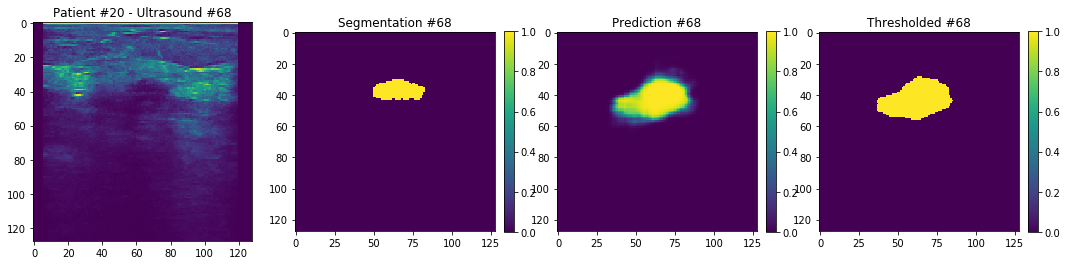

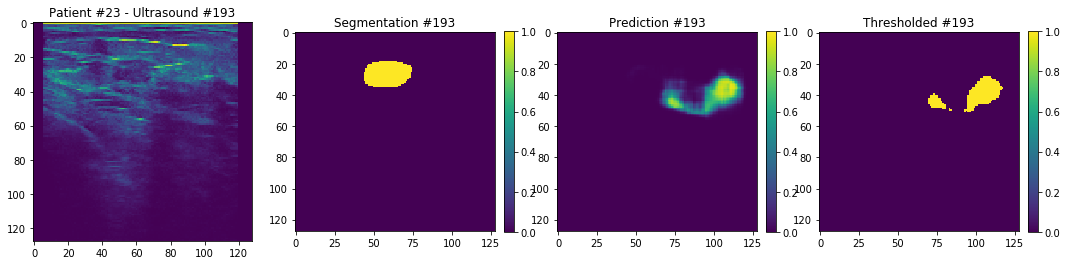

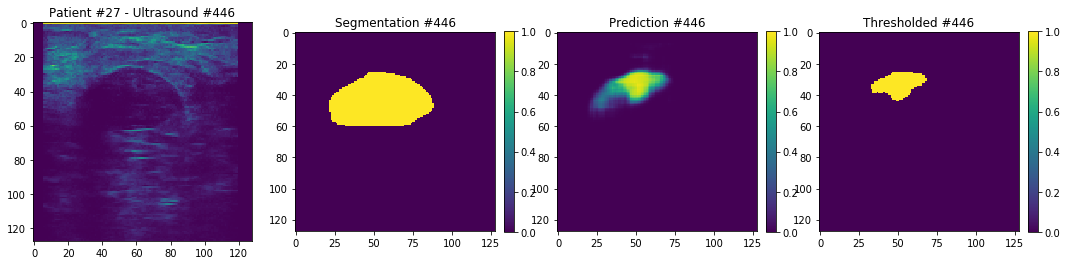

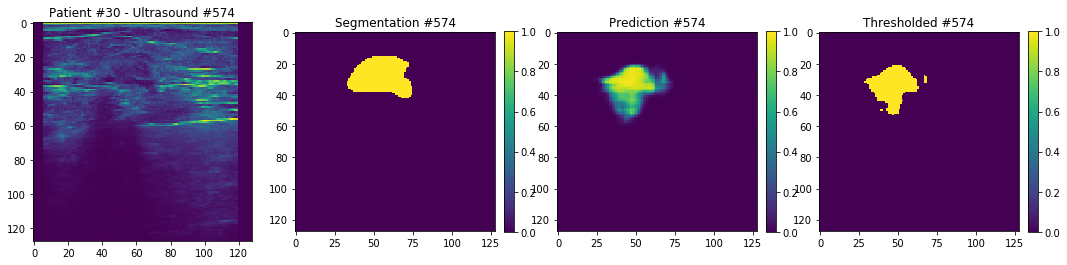

In [16]:
# Display sample results

# determine the available ultrasounds in the last round of validation
last_round = validation_schedule_patient[-1]
print(val_ultrasound_data.shape)
prev_vali = 0
    
for j in range(len(last_round)):
    num_vali =  prev_vali + ultrasound_arrays_by_patients[last_round[j]].shape[0]
    num_show = 1
    if num_vali < num_show:
        num_show = 0
    num_col = 4

    indices = [i for i in range(prev_vali, num_vali)]
    sample_indices = sample(indices, num_show)
    #sample_indices = [prev_vali]
    
    # update
    prev_vali = num_vali
    threshold = 0.5

    fig = plt.figure(figsize=(18, num_show*5))
    for i in range(num_show):
        a0 = fig.add_subplot(num_show, num_col, i*num_col+1)
        img0 = a0.imshow(np.flipud(val_ultrasound_data[sample_indices[i], :, :, 0].astype(np.float32)))
        a0.set_title("Patient #{} - Ultrasound #{}".format(last_round[j], sample_indices[i]))
        a1 = fig.add_subplot(num_show, num_col, i*num_col+2)
        img1 = a1.imshow(np.flipud(val_segmentation_data_onehot[sample_indices[i], :, :, 1]), vmin=0.0, vmax=1.0)
        a1.set_title("Segmentation #{}".format(sample_indices[i]))
        c = fig.colorbar(img1, fraction=0.046, pad=0.04)
        a2 = fig.add_subplot(num_show, num_col, i*num_col+3)
        img2 = a2.imshow(np.flipud(y_pred_val[sample_indices[i], :, :, 1]), vmin=0.0, vmax=1.0)
        a2.set_title("Prediction #{}".format(sample_indices[i]))
        c = fig.colorbar(img2, fraction=0.046, pad=0.04)
        a3 = fig.add_subplot(num_show, num_col, i*num_col+4)
        img3 = a3.imshow((np.flipud(y_pred_val[sample_indices[i], :, :, 1]) > threshold), vmin=0.0, vmax=1.0)
        c = fig.colorbar(img3, fraction=0.046, pad=0.04)
        a3.set_title("Thresholded #{}".format(sample_indices[i]))

In [12]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [13]:
# Export HTML copy of this notebook

notebook_file_name = this_notebook_name + "_" + save_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: c:\Data\BreastSegmentation\SavedNotebooks\BreastSegmentationStudy-TF2_2020-06-28_22-32-52.html
